### Contents

- [Header](#Header)
- [Import Data](#Import-Data)
- [Functions](#Functions)


- [Drop Rows](#Drop-Rows)
- [Select and Merge Sports](#Select-and-Merge-Sports)
- [Select Features](#Select-Features)

- [Plot df_model](#Plot-df_model)
- [Create Features and Target](#Create-Features-and-Target)
- [Handle Imbalanced Data](#Handle-Imbalanced-Data)


- [Logistic Regression Model](#Logistic-Regression-Model)
- [KNN Model](#KNN-Model)
- [DTC Model](#DTC-Model)
- [RTC Model](#RTC-Model)
- [SVC Model](#SVC-Model)


- [Combine Model Predictions](#Combine-Model-Predictions)
- [VotingClassifier Model](#VotingClassifier-Model)
- [GridSearch Model](#GridSearch-Model)

### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error,cohen_kappa_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,VotingClassifier
from sklearn.externals.six import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# file paths

raw_path = '../../data/0_raw/fitrec/' 
input_path = '../../data/1_input/fitrec/'
clean_path = '../../data/2_clean/fitrec/' 
preprocess_path = '../../data/3_preprocess/fitrec/' 
output_path = '../../data/4_output/fitrec/'

sports_path = '../../data/1_input/sports/' 

### Import Data

In [3]:
# import summary csv

#file = 'endomondoHR_proper_summary.csv'
#file = 'endomondoHR_proper_dist_spd_summary.csv'
file = 'endomondoHR_proper_dist_spd_time_summary.csv'

in_path = clean_path + file

df = pd.read_csv(in_path)
df.columns

Index(['id', 'userId', 'gender', 'sport', 'url', 'time_start', 'time_end',
       'time_dur', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'alt_avg',
       'alt_min', 'alt_05', 'alt_25', 'alt_75', 'alt_95', 'alt_max',
       'alt_diff', 'hr_avg', 'hr_min', 'hr_05', 'hr_25', 'hr_75', 'hr_95',
       'hr_max', 'hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak', 'spd_avg',
       'spd_min', 'spd_05', 'spd_25', 'spd_75', 'spd_95', 'spd_max', 'spd_low',
       'spd_med', 'spd_high', 'spd_vhigh', 'impute'],
      dtype='object')

In [4]:
# import sports.xlsx

path = sports_path + 'sports.xlsx'
df_sports = pd.read_excel(path)
df_sports

,sport,sport_rename,type,venue,location_valid,distance_valid,speed_valid,speed_max
0,aerobics,aerobics,gym,indoor,0,0,0,0
1,badminton,badminton,racket,indoor,0,1,0,0
2,basketball,basketball,team,outdoor/indoor,1,1,0,0
3,bike,bike,aerobic,outdoor,1,1,1,244
4,bike (transport),bike,aerobic,outdoor,1,1,1,244
5,indoor cycling,bike,aerobic,indoor,0,1,1,244
6,mountain bike,bike,aerobic,outdoor,1,1,1,244
7,circuit training,circuit training,aerobic,outdoor/indoor,0,0,0,0
8,climbing,climbing,aerobic,outdoor/indoor,1,0,0,0
9,core stability training,core stability training,indoor,indoor,0,0,0,0


### Functions

### Drop Rows

In [5]:
# drop rows with abnormal heartrate

before = len(df)
print('before:',before)

cond_1 = df['hr_min'] >= 40
cond_2 = df['hr_avg'] >= 50
cond_3 = df['hr_max'] >= 60

df = df[cond_1 & cond_2 & cond_3]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167783
after: 167044
drop: 739


In [6]:
# drop rows with abnormal workout duration

before = len(df)
print('before:',before)

# time_dur in minutes
time_dur_mask = df['time_dur'] < 24 * 60
df = df[time_dur_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167044
after: 167040
drop: 4


In [7]:
# drop rows with abnormal altitude

before = len(df)
print('before:',before)

# altitude in metres
max_alt_mask = df['alt_max'] <= 4000 # below Mount Kinabalu
min_alt_mask = df['alt_min'] >= -30 # 10 storeys underground
df = df[max_alt_mask & min_alt_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167040
after: 159104
drop: 7936


In [8]:
# drop rows if speed is nan

# before = len(df)
# print('before:',before)

# df.dropna(subset=['spd_avg'],inplace=True)

# after = len(df)
# print('after:',after)
# drop = before - after
# print('drop:',drop)

### Select and Merge Sports

In [9]:
# print number of workouts per sport (after dropping rows)

df['sport'].value_counts()

bike                       67894
run                        67269
mountain bike              10271
bike (transport)            7147
indoor cycling              1627
walk                        1222
orienteering                 849
cross-country skiing         781
core stability training      434
fitness walking              275
skate                        246
roller skiing                237
hiking                       232
kayaking                      88
circuit training              86
rowing                        70
weight training               69
gymnastics                    66
soccer                        51
downhill skiing               43
treadmill running             27
snowshoeing                   16
swimming                      13
golf                          12
elliptical                    10
horseback riding              10
badminton                      9
basketball                     8
tennis                         8
aerobics                       7
climbing  

In [10]:
# select only sports with speed_valid = 1

valid_mask = df_sports['speed_valid'] == 1
valid_sport_list = df_sports[valid_mask]['sport']
valid_sport_list = list(valid_sport_list)

# overwrite: compare specific sports
#valid_sport_list = ['kayaking','rowing']

valid_mask_2 = df['sport'].isin(valid_sport_list)
df = df[valid_mask_2]
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'mountain bike', 'rowing',
       'orienteering', 'kayaking', 'indoor cycling', 'skate',
       'cross-country skiing', 'walk', 'hiking', 'treadmill running',
       'snowshoeing', 'snowboarding', 'fitness walking', 'roller skiing',
       'horseback riding', 'downhill skiing', 'swimming',
       'treadmill walking', 'sailing', 'kite surfing', 'windsurfing'],
      dtype=object)

In [11]:
# merge similar sports

for idx,row in df_sports.iterrows():
    
    sport = row['sport'].rstrip()
    sport_rename = row['sport_rename']
    print(sport,sport_rename)
    
    df['sport'].replace(sport,sport_rename,inplace=True)

aerobics aerobics
badminton badminton
basketball basketball
bike bike
bike (transport) bike
indoor cycling bike
mountain bike bike
circuit training circuit training
climbing climbing
core stability training core stability training
elliptical elliptical
golf golf
gymnastics gymnastics
hiking hiking
horseback riding horseback riding
kayaking kayaking
martial arts martial arts
orienteering orienteering
rowing rowing       
rugby rugby
run run
treadmill running run
sailing sailing
skate skate
cross-country skiing skiing
downhill skiing skiing
roller skiing skiing
snowboarding snowboarding
snowshoeing snowshoeing
soccer soccer
squash squash
stair climing stair climbing
kite surfing surfing
windsurfing surfing
swimming swimming
table tennis table tennis
tennis tennis
fitness walking walk
treadmill walking walk
walk walk
weight training weight training
pilates yoga
yoga yoga


In [12]:
# print number of workouts per sport (after selecting and merging sports)

df['sport'].value_counts()

bike                86939
run                 67296
walk                 1498
skiing               1061
orienteering          849
skate                 246
hiking                232
kayaking               88
rowing                 70
snowshoeing            16
swimming               13
horseback riding       10
snowboarding            3
surfing                 2
sailing                 1
Name: sport, dtype: int64

### Select Features

In [13]:
# feature selection (select columns for df_model)

# cols = ['sport','time_dur','alt_avg','alt_min','alt_25','alt_75','alt_max','hr_avg', 'hr_min','hr_25','hr_75','hr_max']

#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_05','hr_25','hr_75','hr_95','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','spd_avg']
#cols = ['sport','spd_avg','spd_95']
#cols = ['sport','spd_avg','spd_05','spd_25','spd_75','spd_95']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_95']
#cols = ['sport','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_25','spd_75']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_low','spd_med','spd_high','spd_vhigh']

#cols = ['sport']

# for i in range(4):
#     for j in range(4):
#         col_name = 'spd_hr_{}_{}'.format(i,j)
#         cols.append(col_name)

df_model = df[cols]

In [14]:
# select only sports with minimal rows

count = df_model['sport'].value_counts()

#count_cond = count[count > 1].index
#count_cond = count[count >= 5].inde
#count_cond = count[count >= 10].index
count_cond = count[count >= 50].index
#count_cond = count[count >= 70].index
#count_cond = count[count >= 100].index
#count_cond = count[count >= 200].index
#count_cond = count[count >= 800].index
#count_cond = count[count >= 1500].index
#count_cond = count[count >= 70000].index

count_mask = df_model['sport'].isin(count_cond)
df_model = df_model[count_mask]

In [15]:
print(df_model.shape)
df_model.head()

(158279, 7)


,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,bike,0.0,0.0076,0.4943,0.4982,26.434232,41.293440
1,bike,0.0,0.0105,0.6382,0.3513,27.426005,43.088400
2,bike,0.0,0.0897,0.7909,0.1194,26.195207,40.128480
3,bike,0.0,0.0290,0.6923,0.2786,26.990473,42.182640
4,bike,0.0,0.0054,0.0715,0.9231,31.370962,46.416971


In [16]:
# print number of workout by sports (with minimal rows)

df_model['sport'].value_counts()

bike             86939
run              67296
walk              1498
skiing            1061
orienteering       849
skate              246
hiking             232
kayaking            88
rowing              70
Name: sport, dtype: int64

### Plot df_model

In [17]:
# order = df_model.groupby('sport')['hr_max'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_max',y='sport',order=order);

In [18]:
# order = df_model.groupby('sport')['hr_avg'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_avg',y='sport',order=order);

In [19]:
# order = df_model.groupby('sport')['hr_min'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_min',y='sport',order=order);

### Create Features and Target

In [20]:
df_model.head()

,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,bike,0.0,0.0076,0.4943,0.4982,26.434232,41.293440
1,bike,0.0,0.0105,0.6382,0.3513,27.426005,43.088400
2,bike,0.0,0.0897,0.7909,0.1194,26.195207,40.128480
3,bike,0.0,0.0290,0.6923,0.2786,26.990473,42.182640
4,bike,0.0,0.0054,0.0715,0.9231,31.370962,46.416971


In [21]:
# doing scaling and encoding before create X and y

cols = df_model.columns[1:]

ss = StandardScaler()
df_model[cols] = ss.fit_transform(df_model[cols])

le = LabelEncoder()
df_model['sport'] = le.fit_transform(df_model['sport'])

In [22]:
# create feature and target. next perform train_test_split

X = df_model.drop(columns='sport')
y = df_model['sport']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [23]:
df_model.head()

,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,0,-0.31424,-0.840490,0.077987,0.687685,0.985468,1.201451
1,0,-0.31424,-0.829137,0.567147,0.231259,1.103400,1.339761
2,0,-0.31424,-0.519083,1.086221,-0.489266,0.957045,1.111685
3,0,-0.31424,-0.756713,0.751049,0.005376,1.051611,1.269968
4,0,-0.31424,-0.849102,-1.359239,2.007871,1.572499,1.596244


### Handle Imbalanced Data

In [ ]:
# check before upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(110795, 6)
(47484, 6)
(110795,)
(47484,)


In [ ]:
# check before upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 60857, 1: 162, 2: 62, 3: 594, 4: 49, 5: 47107, 6: 172, 7: 743, 8: 1049}

In [ ]:
# sm = SMOTE(random_state=3050)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [ ]:
# get majority class index and row count

# sport_counts = df_model['sport'].value_counts()
# print(sport_counts)

# major_class_index = sport_counts.index[0]
# major_class_count = sport_counts.values[0]
# print(major_class_index,major_class_count)

In [ ]:
# concatenate our training data back together

Xy_train = pd.concat([X_train, y_train], axis=1)

sport_counts = Xy_train['sport'].value_counts()
print(sport_counts)

print(Xy_train.shape)
Xy_train.head()

0    60857
5    47107
8     1049
7      743
3      594
6      172
1      162
2       62
4       49
Name: sport, dtype: int64
(110795, 7)


,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,sport
124562,-0.061598,2.063528,-0.830987,-0.860248,1.631111,1.049492,0
114287,8.287323,-0.705428,-1.120267,-0.831353,0.301222,0.435806,0
63157,-0.314240,-0.870242,-0.920048,1.623218,1.701849,0.903689,0
135169,0.781609,0.110030,0.322737,-0.610131,0.287753,0.352109,0
130855,-0.314240,-0.602077,0.770426,-0.134752,-0.875509,-1.034707,5


In [ ]:
# perform upsampling and downsampling

sample_size = 12000

df_all_sample = pd.DataFrame()

sport_list = df_model['sport'].unique()
sport_list

for sport in sport_list:
    
    cond = Xy_train['sport'] == sport
    df_sport = Xy_train[cond]
    
    # perform downsampling
    if sport_counts[sport] >= sample_size:    
        print('downsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=False,random_state=3050)
        
    # perform upsampling
    # sport_counts[sport] < sample_size: 
    else:
        print('upsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=True,random_state=3050)
        
    df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
    
X_train = df_all_sample.drop(columns='sport').values
y_train = df_all_sample['sport'].values

downsampling 0 60857
downsampling 5 47107
upsampling 4 49
upsampling 3 594
upsampling 2 62
upsampling 6 172
upsampling 7 743
upsampling 8 1049
upsampling 1 162


In [ ]:
# # perform upsampling for minority classes

# df_all_sample = pd.DataFrame()

# sport_list = df_model['sport'].unique()

# for sport in sport_list:
    
#     if sport != major_class_index:
        
#         cond = df_model['sport'] == sport
#         df_sport = df_model[cond]
#         #print(sport,len(df_sport))
        
#         df_sample = df_sport.sample(major_class_count,replace=True,random_state=3050)
#         df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
        
# cond = df_model['sport'] == major_class_index
# df_top = df_model[cond]
# df_all_sample = pd.concat([df_all_sample, df_top], axis=0)

# X_train = df_all_sample.drop(columns='sport').values
# y_train = df_all_sample['sport'].values

In [ ]:
# check after upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108000, 6)
(47484, 6)
(108000,)
(47484,)


In [ ]:
# check after upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 12000,
 1: 12000,
 2: 12000,
 3: 12000,
 4: 12000,
 5: 12000,
 6: 12000,
 7: 12000,
 8: 12000}

In [ ]:
# store predictions in df_pred

df_pred = pd.DataFrame()

### Logistic Regression Model

In [ ]:
# init model
logreg = LogisticRegression()

# perform cross validation
score = cross_val_score(logreg,X,y,cv=5)
print('score:',score.mean(),score)

# fit model
logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

score: 0.9457226298585383 [0.94049274 0.94374072 0.95106773 0.94484109 0.94847087]
train r2: 0.5080277777777777
test r2: 0.7223275208491281


Logisitic Regression Model
rows:actual columns:predicted

f1_score: 0.7223275208491281
accuracy_score: 0.7223275208491281


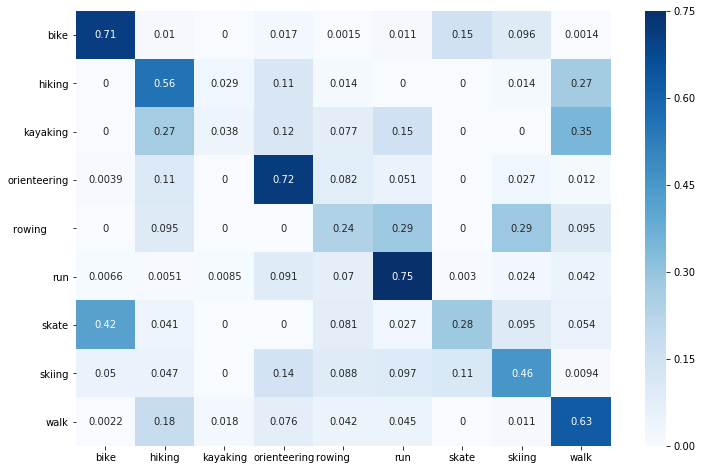

In [ ]:
# confusion matrix
print('Logisitic Regression Model')
print('rows:actual columns:predicted')
print('')

y_pred = logreg.predict(X_test)
df_pred['lr'] = y_pred

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### KNN Model

In [ ]:
# init model
knn = KNeighborsClassifier(n_neighbors=3)

# perform cross validation
score = cross_val_score(knn,X,y,cv=5)
print('score:',score.mean(),score)

# fit model
knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

score: 0.9575052988253827 [0.96020215 0.9568184  0.95656432 0.95972073 0.9542209 ]
train r2: 0.9874351851851851
test r2: 0.9048942801785864


KNN Model
rows:actual columns:predicted
f1_score: 0.9048942801785864
accuracy_score: 0.9048942801785864


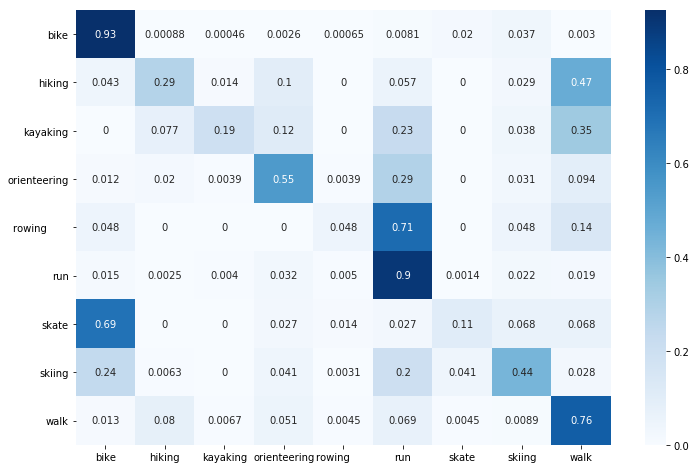

In [ ]:
# confusion matrix
print('KNN Model')
print('rows:actual columns:predicted')

y_pred = knn.predict(X_test)
df_pred['knn'] = y_pred

# y_pred = knn.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### DTC Model

In [ ]:
# init model
dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)

# perform cross validation
score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

0.960190424010745 [0.96298168 0.96051426 0.95811221 0.96231124 0.95703273]
train r2: 0.8633611111111111
test r2: 0.7745766995198382


DTC Model
rows:actual columns:predicted
f1_score: 0.7745766995198382
accuracy_score: 0.7745766995198382


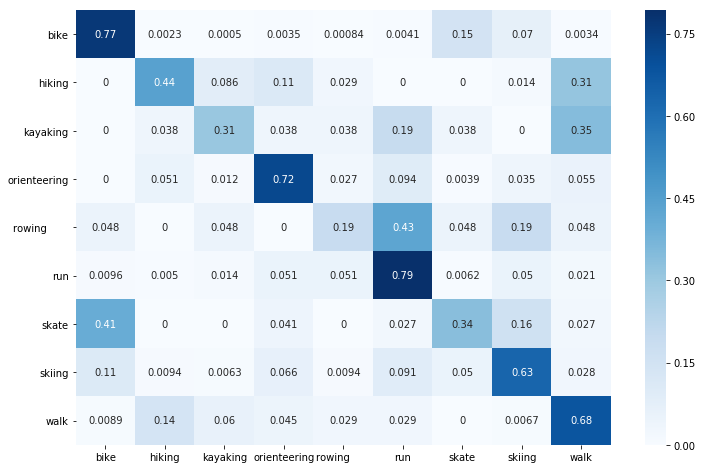

In [ ]:
# confusion matrix
print('DTC Model')
print('rows:actual columns:predicted')

y_pred = dtc.predict(X_test)
df_pred['dtc'] = y_pred

# y_pred = dtc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

In [ ]:
# # initialize the output file object
# dot_data = StringIO() 

# # my fit DecisionTreeRegressor object here is: dtr1
# # for feature_names i put the columns of my Xr matrix
# export_graphviz(dtc, 
#                 out_file=dot_data,  
#                 filled=True, 
#                 rounded=True,
#                 special_characters=True,
#                 feature_names=df_model[features].columns
#                )  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### RFC Model

In [ ]:
# init model
rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1, random_state=3050)

# perform cross validation
score = cross_val_score(rfc,X,y,cv=5)
print(score.mean(),score)

# fit model
rfc = rfc.fit(X_train,y_train)

# score model
print("train r2:",rfc.score(X_train, y_train))
print("test r2:",rfc.score(X_test, y_test))



0.9634947438436005 [0.9657928  0.96300976 0.96190296 0.96641815 0.96035006]
train r2: 0.9039722222222222
test r2: 0.8298374189200572


RFC Model
rows:actual columns:predicted
f1_score: 0.8298374189200572
accuracy_score: 0.8298374189200572


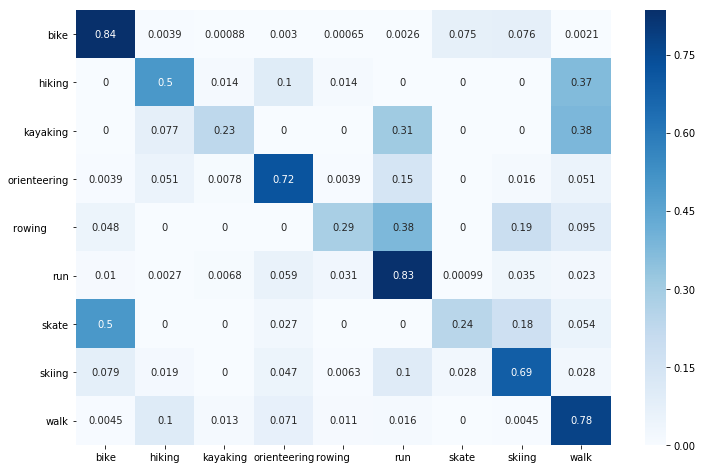

In [ ]:
# confusion matrix
print('RFC Model')
print('rows:actual columns:predicted')

y_pred = rfc.predict(X_test)
df_pred['rfc'] = y_pred

# y_pred = rfc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### SVC Model

In [ ]:
# init model
svc = SVC()

# fit model
svc.fit(X_train, y_train)

# score model
print("train r2:",svc.score(X_train, y_train))
print("test r2:",svc.score(X_test, y_test))

train r2: 0.7143425925925926
test r2: 0.721042877600876


SVC Model
rows:actual columns:predicted
f1_score: 0.721042877600876
accuracy_score: 0.721042877600876


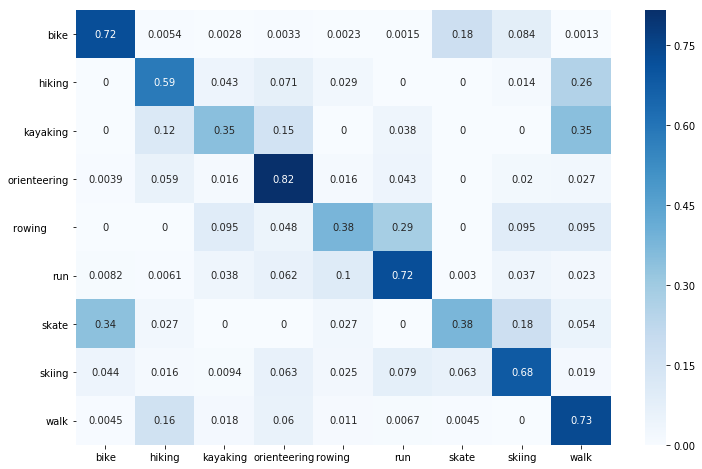

In [ ]:
# confusion matrix
print('SVC Model')
print('rows:actual columns:predicted')

y_pred = svc.predict(X_test)
df_pred['svc'] = y_pred

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### Combine Model Predictions

In [ ]:
# check predictions

# print(df_pred.shape)
# df_pred.head()

In [ ]:
# cols = ['svc','rfc','dtc','lr','knn']
# df_pred = df_pred[cols]

# df_pred_mode = df_pred.mode(axis=1)
# df_pred_mode.reset_index(inplace=True)

# df_pred_final = df_pred_mode[0]

In [ ]:
# for idx,row in df_pred_mode.iterrows():
    
#     if np.isnan(row[1]) == False:

#         mode_list = list(row[1:])
#         #print(mode_list)
        
#         pred_row = df_pred.iloc[idx,:]
#         #print(pred_row)
        
        
#         for idx_2,cell in pred_row.iteritems():
            
#             if cell in mode_list:
#                 #print(idx,idx_2,cell)
#                 df_pred_final[idx] = cell
#                 break

In [ ]:
# # confusion matrix
# print('Combined Model')
# print('rows:actual columns:predicted')

# y_pred_final = df_pred_final.values

# f1 = f1_score(y_test, y_pred,average='micro')
# accuracy = accuracy_score(y_test,y_pred)
# print('f1_score:',f1)
# print('accuracy_score:',accuracy)

# # cohen_score = cohen_kappa_score(y_test, y_pred)
# # print('cohen_score',cohen_score)

# cm = confusion_matrix(y_test, y_pred_final)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

# plt.figure(figsize=(12,8))
# sns.heatmap(df_cm,annot=True,cmap="Blues");

### VotingClassifier Model

In [ ]:
# init models

lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)
dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)
rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1, random_state=3050)
svc = SVC()

In [ ]:
# lr knn dtc rfc svc

estimators = [
        ('lr', lr), 
        ('knn', knn), 
        ('dtc', dtc),
        ('rfc', rfc),
        ('svc', svc)
            ]

vc = VotingClassifier(estimators=estimators, voting='hard')
#vc = VotingClassifier(estimators=estimators, voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

VC Model
rows:actual columns:predicted
f1_score: 0.8394195939684947
accuracy_score: 0.8394195939684946


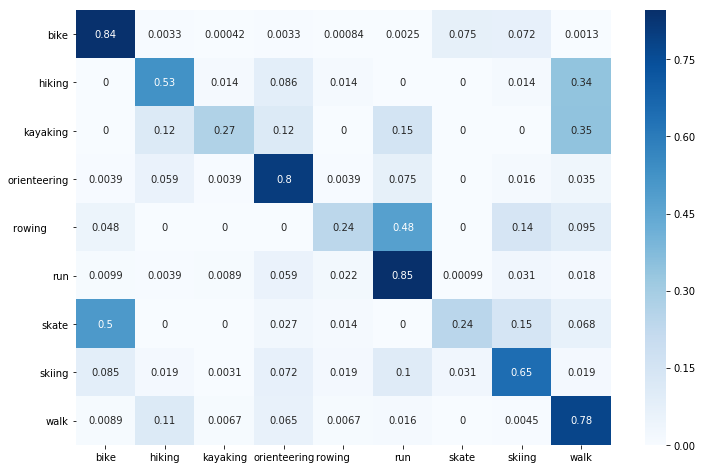

In [ ]:
# confusion matrix
print('VC Model')
print('rows:actual columns:predicted')

f1 = f1_score(y_test, y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
print('f1_score:',f1)
print('accuracy_score:',accuracy)

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### GridSearch Model

In [ ]:
# init models

estimators = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'abc': AdaBoostClassifier(),
    'gbc': GradientBoostingClassifier()
}.items()

In [ ]:
# init model parameters

params = {
    'lr': {
        'lr__penalty': ['l1','l2'],
        #'lr__penalty': ['l1','l2','elasticnet'],
        #'l1__ratio': np.arange(.1, 1, .2)
    },
    'knn': {
        'knn__n_neighbors': [3,5,7,9],
        'knn__weights': ['uniform','distance']
    },

    'dtc': {
        'dtc__max_features': ['auto', 'log2', None],
        'dtc__max_depth': np.arange(3, 16, 2),
        'dtc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'rfc': {
        'rfc__n_estimators': [10, 15, 20, 25],
        'rfc__max_features': ['auto', 'log2', None],
        'rfc__max_depth': np.arange(3, 16, 2),
        'rfc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'abc': {
        'abc__n_estimators' : np.arange(50, 151, 25),
        'abc__learning_rate' : np.linspace(0.1, 1, 8)
    }, 
    'gbc': {
        'gbc__n_estimators' : np.arange(10, 101, 30),
        'gbc__learning_rate' : np.linspace(0.1, 1, 4),
        'gbc__max_depth' : [1, 2, 3]
    }
}

In [ ]:
models = []
parameters = []
best_score = []
roc_auc = []

for k,v in estimators:
    
    pipe = Pipeline([
            #('sc', StandardScaler()),
            (k,v)
                    ])
    
    gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=params[k],
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True
    )

    gridsearch.fit(X_train, y_train)
    
    model = gridsearch.best_estimator_
    cv_score = gridsearch.cv_results_
    best_params = gridsearch.best_params_

    # predict y
    y_pred = model.predict(X_test)
    #y_pred = model.predict_proba(X_test)
    
    # print results
    print("Model: ", k)
    print("Best parameters:", best_params)
    print("Best score:", gridsearch.best_score_)
    display(pd.DataFrame(cv_score, columns = cv_score.keys()))    
    
    # append info to list
    models.append(k)
    best_score.append(gridsearch.best_score_)
    parameters.append(best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


Model:  lr
Best parameters: {'lr__penalty': 'l1'}
Best score: 0.5085555555555555


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,69.628175,14.966569,0.018747,0.022959,l1,{'lr__penalty': 'l1'},0.509815,0.506481,0.506713,0.509954,...,0.508556,0.001601,1,0.509282,0.509155,0.508738,0.508854,0.508113,0.508829,0.000408
1,3.402328,0.156651,0.006249,0.007653,l2,{'lr__penalty': 'l2'},0.508750,0.506435,0.506898,0.510000,...,0.508380,0.001470,2,0.508299,0.509074,0.508738,0.508669,0.507928,0.508542,0.000393


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   50.4s finished


Model:  knn
Best parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score: 0.9771666666666666


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.258677,0.022140,1.713457,0.039119,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.979167,0.976157,0.975648,...,0.976648,0.001284,2,0.985532,0.985475,0.985984,0.986111,0.985463,0.985713,0.000277
1,0.212451,0.015929,0.552996,0.032166,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.979537,0.976574,0.975972,...,0.977167,0.001241,1,0.999873,0.999479,0.999826,0.999838,0.999803,0.999764,0.000144
2,0.174959,0.015307,1.418418,0.156961,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.971852,0.969676,0.970648,...,0.970778,0.000718,4,0.977292,0.977280,0.977905,0.977859,0.977384,0.977544,0.000279
3,0.178083,0.007652,0.453020,0.013972,5,distance,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.973287,0.970926,0.971528,...,0.972111,0.000832,3,0.999873,0.999479,0.999826,0.999838,0.999803,0.999764,0.000144
4,0.168712,0.006249,1.334061,0.032166,7,uniform,"{'knn__n_neighbors': 7, 'knn__weights': 'unifo...",0.966574,0.965278,0.965278,...,0.965750,0.000537,6,0.971100,0.971458,0.971377,0.971250,0.971331,0.971303,0.000122
5,0.174960,0.011689,0.499882,0.017112,7,distance,"{'knn__n_neighbors': 7, 'knn__weights': 'dista...",0.969074,0.967222,0.967407,...,0.968009,0.000660,5,0.999873,0.999826,0.999826,0.999838,0.999803,0.999833,0.000023
6,0.162463,0.007652,1.355932,0.011689,9,uniform,"{'knn__n_neighbors': 9, 'knn__weights': 'unifo...",0.960926,0.958241,0.959213,...,0.960000,0.001128,8,0.965509,0.965822,0.965787,0.965683,0.966076,0.965775,0.000186
7,0.165586,0.007652,0.556120,0.015930,9,distance,"{'knn__n_neighbors': 9, 'knn__weights': 'dista...",0.965694,0.962778,0.963750,...,0.964157,0.000985,7,0.999873,0.999826,0.999826,0.999838,0.999803,0.999833,0.000023


Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:   23.0s finished


Model:  dtc
Best parameters: {'dtc__max_depth': 5, 'dtc__max_features': None, 'dtc__min_samples_split': 0.1}
Best score: 0.5766111111111111


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__max_depth,param_dtc__max_features,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.144738,0.012744,0.006916,0.007213,3,auto,0.1,"{'dtc__max_depth': 3, 'dtc__max_features': 'au...",0.368102,0.353287,...,0.395389,0.029233,47,0.365926,0.353241,0.428912,0.419120,0.412593,0.395958,0.030417
1,0.127117,0.013218,0.011964,0.004488,3,auto,0.2,"{'dtc__max_depth': 3, 'dtc__max_features': 'au...",0.427361,0.408843,...,0.381037,0.053775,51,0.423877,0.408866,0.304468,0.333183,0.432917,0.380662,0.051872
2,0.109351,0.009880,0.009373,0.007653,3,auto,0.3,"{'dtc__max_depth': 3, 'dtc__max_features': 'au...",0.388519,0.344259,...,0.365676,0.016299,56,0.388333,0.349988,0.373275,0.373773,0.352338,0.367542,0.014445
3,0.096853,0.006248,0.003124,0.006249,3,auto,0.4,"{'dtc__max_depth': 3, 'dtc__max_features': 'au...",0.241667,0.300093,...,0.270185,0.037456,102,0.244722,0.302269,0.212199,0.295926,0.301470,0.271317,0.036538
4,0.090604,0.011690,0.006249,0.007653,3,auto,0.5,"{'dtc__max_depth': 3, 'dtc__max_features': 'au...",0.199167,0.277870,...,0.279102,0.042471,98,0.198148,0.277801,0.319757,0.290880,0.309861,0.279289,0.043111
5,0.124971,0.009880,0.003124,0.006248,3,log2,0.1,"{'dtc__max_depth': 3, 'dtc__max_features': 'lo...",0.433194,0.337963,...,0.394417,0.054851,48,0.427697,0.343449,0.390752,0.331968,0.478773,0.394528,0.054285
6,0.118722,0.012497,0.009372,0.007652,3,log2,0.2,"{'dtc__max_depth': 3, 'dtc__max_features': 'lo...",0.412917,0.401991,...,0.404722,0.009864,44,0.410498,0.405567,0.395301,0.420694,0.398148,0.406042,0.009082
7,0.118723,0.012497,0.003124,0.006248,3,log2,0.3,"{'dtc__max_depth': 3, 'dtc__max_features': 'lo...",0.339676,0.319213,...,0.350889,0.026970,61,0.341157,0.319039,0.400197,0.350718,0.338264,0.349875,0.027183
8,0.099976,0.007652,0.018745,0.011690,3,log2,0.4,"{'dtc__max_depth': 3, 'dtc__max_features': 'lo...",0.320093,0.318843,...,0.310065,0.036665,87,0.319375,0.319688,0.306192,0.247222,0.357743,0.310044,0.035824
9,0.107126,0.019203,0.004121,0.006065,3,log2,0.5,"{'dtc__max_depth': 3, 'dtc__max_features': 'lo...",0.266620,0.318843,...,0.290861,0.024464,94,0.266285,0.319688,0.317384,0.262674,0.290012,0.291208,0.024220


Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 14.9min finished


Model:  rfc
Best parameters: {'rfc__max_depth': 13, 'rfc__max_features': 'auto', 'rfc__min_samples_split': 0.1, 'rfc__n_estimators': 20}
Best score: 0.5908518518518519


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_split,param_rfc__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.738155,0.026956,0.046863,1.051207e-06,3,auto,0.1,10,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.540046,...,0.545935,0.007420,52,0.539340,0.537176,0.548576,0.553137,0.558009,0.547248,0.007953
1,1.043507,0.011691,0.074983,6.247760e-03,3,auto,0.1,15,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.529444,...,0.526509,0.023637,80,0.524167,0.527361,0.491933,0.528461,0.567593,0.527903,0.024015
2,1.368430,0.023380,0.093728,1.353747e-06,3,auto,0.1,20,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.566991,...,0.543954,0.012172,54,0.562789,0.545579,0.536863,0.535382,0.539792,0.544081,0.009984
3,1.690232,0.028634,0.112474,6.248904e-03,3,auto,0.1,25,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.556898,...,0.559583,0.007017,49,0.549664,0.555845,0.560150,0.560174,0.572072,0.559581,0.007335
4,0.615481,0.027238,0.049989,6.247115e-03,3,auto,0.2,10,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.470509,...,0.469491,0.020845,140,0.466852,0.482662,0.428900,0.481875,0.485347,0.469127,0.021129
5,0.921661,0.022091,0.071858,7.652222e-03,3,auto,0.2,15,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.522454,...,0.485463,0.023321,126,0.519259,0.492812,0.449097,0.481204,0.482512,0.484977,0.022558
6,1.209093,0.042609,0.084354,7.652047e-03,3,auto,0.2,20,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.483657,...,0.484324,0.004887,129,0.485301,0.495706,0.490868,0.477870,0.478530,0.485655,0.006924
7,1.484030,0.035621,0.118722,7.651989e-03,3,auto,0.2,25,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.485185,...,0.496056,0.017440,101,0.484433,0.519039,0.471273,0.497674,0.514375,0.497359,0.017929
8,0.525548,0.013684,0.047317,9.066353e-04,3,auto,0.3,10,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.428148,...,0.413352,0.011651,179,0.427118,0.398542,0.409225,0.420741,0.416053,0.414336,0.009828
9,0.760538,0.024656,0.062486,1.749414e-06,3,auto,0.3,15,"{'rfc__max_depth': 3, 'rfc__max_features': 'au...",0.429306,...,0.415620,0.012666,172,0.424977,0.402569,0.430463,0.421493,0.402350,0.416370,0.011713


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.5min finished


Model:  abc
Best parameters: {'abc__learning_rate': 0.2285714285714286, 'abc__n_estimators': 150}
Best score: 0.495787037037037


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_abc__learning_rate,param_abc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.901369,0.813627,0.752949,0.065833,0.1,50,"{'abc__learning_rate': 0.1, 'abc__n_estimators...",0.394583,0.404630,0.388056,...,0.391861,0.007558,35,0.395683,0.403935,0.385648,0.384225,0.391250,0.392148,0.007173
1,11.077997,0.098848,0.993519,0.025381,0.1,75,"{'abc__learning_rate': 0.1, 'abc__n_estimators...",0.395370,0.400972,0.415972,...,0.400574,0.008009,32,0.395660,0.399803,0.413750,0.398090,0.396736,0.400808,0.006618
2,14.755451,0.080290,1.327816,0.027946,0.1,100,"{'abc__learning_rate': 0.1, 'abc__n_estimators...",0.420185,0.418056,0.419676,...,0.412648,0.008192,29,0.420752,0.418947,0.415463,0.405174,0.404051,0.412877,0.006968
3,18.706487,0.468475,1.751016,0.139536,0.1,125,"{'abc__learning_rate': 0.1, 'abc__n_estimators...",0.419491,0.413009,0.427037,...,0.415509,0.007050,28,0.421563,0.411933,0.423762,0.408032,0.415428,0.416144,0.005855
4,26.837962,2.186778,2.223187,0.315510,0.1,150,"{'abc__learning_rate': 0.1, 'abc__n_estimators...",0.434907,0.419074,0.423843,...,0.422185,0.006983,26,0.434039,0.418924,0.419907,0.415081,0.423264,0.422243,0.006449
5,7.445138,0.062952,0.652972,0.011691,0.228571,50,"{'abc__learning_rate': 0.2285714285714286, 'ab...",0.439769,0.431852,0.435972,...,0.432759,0.005769,23,0.440405,0.432257,0.432488,0.426146,0.434317,0.433123,0.004567
6,10.988117,0.092523,0.981021,0.024994,0.228571,75,"{'abc__learning_rate': 0.2285714285714286, 'ab...",0.434213,0.450787,0.455093,...,0.445556,0.009325,16,0.433576,0.451516,0.451516,0.435521,0.454155,0.445257,0.008818
7,14.818583,0.198128,1.362180,0.116230,0.228571,100,"{'abc__learning_rate': 0.2285714285714286, 'ab...",0.436481,0.473796,0.493333,...,0.462954,0.019851,3,0.436574,0.476366,0.486262,0.463403,0.449016,0.462324,0.017953
8,18.384156,0.063639,1.643367,0.022959,0.228571,125,"{'abc__learning_rate': 0.2285714285714286, 'ab...",0.467176,0.505833,0.520556,...,0.486167,0.025673,2,0.465752,0.509294,0.513657,0.488356,0.454676,0.486347,0.023254
9,22.053053,0.096673,1.952669,0.032768,0.228571,150,"{'abc__learning_rate': 0.2285714285714286, 'ab...",0.505741,0.515509,0.512037,...,0.495787,0.019029,1,0.503044,0.519595,0.506030,0.473819,0.478032,0.496104,0.017445


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 52.5min


In [ ]:
# output gridsearch results

print(models)
print(best_score)
print(parameters)